In [1]:
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler, random_split
import torch.nn as nn

from PIL import Image
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xml.etree.ElementTree as ET

In [2]:
def crop_image(breed, dog, data_dir):
  img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
  tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
  xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
  xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
  ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
  ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
  img = img[ymin:ymax, xmin:xmax, :]
  return img

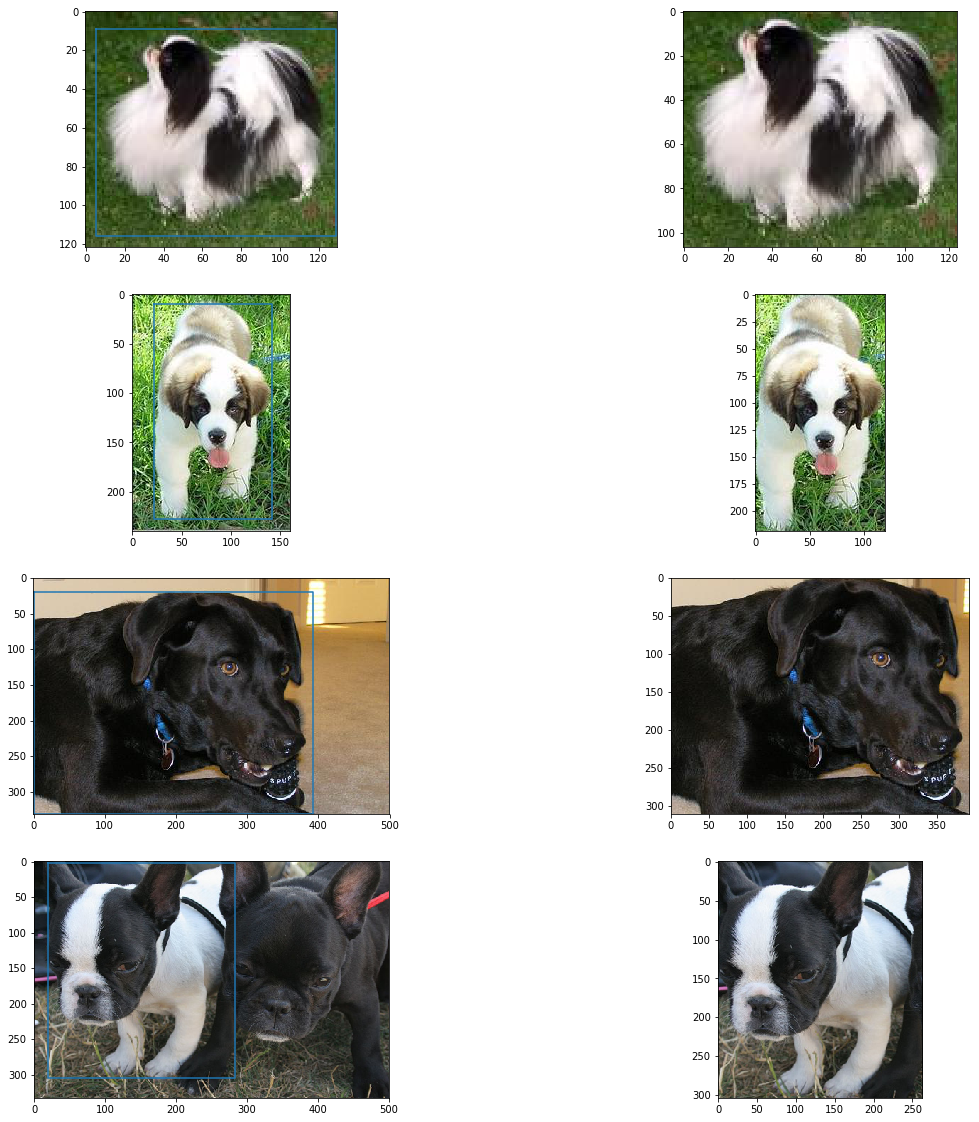

In [3]:
data_dir = '../input/stanford-dogs-dataset/'
breed_list = os.listdir(data_dir + 'images/Images/')

plt.figure(figsize=(20, 20))
for i in range(4):
  plt.subplot(421 + (i*2))
  breed = np.random.choice(breed_list)
  dog = np.random.choice(os.listdir(data_dir + 'annotations/Annotation/' + breed))
  img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
  plt.imshow(img)  
  
  tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + dog)
  xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
  xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
  ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
  ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
  plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
  crop_img = crop_image(breed, dog, data_dir)
  plt.subplot(422 + (i*2))
  plt.imshow(crop_img)

In [5]:
if 'data' not in os.listdir():
    os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

Created 120 folders to store cropped images of the different breeds.


In [7]:
for breed in os.listdir('data'):
    for file in os.listdir(data_dir + 'annotations/Annotation/' + breed):
        img = Image.open(data_dir + 'images/Images/' + breed + '/' + file + '.jpg')
        tree = ET.parse(data_dir + 'annotations/Annotation/' + breed + '/' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('data/' + breed + '/' + file + '.jpg')

In [14]:
all_data = datasets.ImageFolder(root='data')
items = []
for item in all_data.class_to_idx.items():
    items.append(item[0].split("-")[1])

f = open('dog_labels.txt', 'w')
for it in items :
    f.write(it + "\n")

f.close()
    

TypeError: unsupported operand type(s) for +: '_io.TextIOWrapper' and 'str'

In [ ]:
img_count = 0
for folder in os.listdir('data'):
    for _ in os.listdir('data/' + folder):
        img_count += 1
print('No. of Images: {}'.format(img_count))

In [ ]:
image_transforms = {
 
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=299), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=299),
        transforms.CenterCrop(size=299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
batch_size = 128

all_data = datasets.ImageFolder(root='data')
train_data_len = int(len(all_data)*0.8)
valid_data_len = int((len(all_data) - train_data_len)/2)
test_data_len = int(len(all_data) - train_data_len - valid_data_len)
train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
train_data.dataset.transform = image_transforms['train']
val_data.dataset.transform = image_transforms['test']
test_data.dataset.transform = image_transforms['test']
print(len(train_data), len(val_data), len(test_data))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
print(features.shape, labels.shape)

In [ ]:
model = models.inception_v3(pretrained=True)
model.aux_logits=False
model

In [ ]:

for param in model.parameters():
    param.requires_grad = False

In [ ]:
n_classes = 120
n_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, n_classes),
    nn.LogSoftmax(dim=1))

model.fc

In [ ]:
model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
model.class_to_idx = all_data.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

In [ ]:
def train(model,
         criterion,
         optimizer,
         train_loader,
         val_loader,
         save_location,
         early_stop=3,
         n_epochs=20,
         print_every=2):
    
    valid_loss_min = np.Inf
    stop_count = 0
    valid_max_acc = 0
    history = []
    model.epochs = 0

    
    for epoch in range(n_epochs):
        
        train_loss = 0
        valid_loss = 0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.cuda(), label.cuda()
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            
            train_loss += loss.item() * data.size(0)

          
            _, pred = torch.max(output, dim=1) 
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor)) 
            train_acc += accuracy.item() * data.size(0)
            if ii%10 == 0:
                print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.')

        model.epochs += 1
        with torch.no_grad():
            model.eval()

            for data, label in val_loader:
                data, label = data.cuda(), label.cuda()

                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(label.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(val_loader.dataset)

            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(val_loader.dataset)

            history.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}')
                print(f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%')

            if valid_loss < valid_loss_min:
                torch.save({
                    'state_dict': model.state_dict(),
                    'idx_to_class': model.idx_to_class
                }, save_location)
                stop_count = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                stop_count += 1

               
                if stop_count >= early_stop:
                    print(f'\nEarly Stopping Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')
                    model.load_state_dict(torch.load(save_location)['state_dict'])
                    model.optimizer = optimizer
                    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
                    return model, history

    model.optimizer = optimizer
    print(f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%')

    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_location='./dog_inception.pt',
    early_stop=3,
    n_epochs=30,
    print_every=2)

In [ ]:
history

In [ ]:
def test(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()

            output = model(data)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)

        test_acc = test_acc / len(test_loader.dataset)
        return test_acc

In [ ]:
model.load_state_dict(torch.load('./dog_inception.pt')['state_dict'])
test_acc = test(model.cuda(), test_loader, criterion)
print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')

In [ ]:
def evaluate(model, test_loader, criterion):
  
    classes = []
    acc_results = np.zeros(len(test_loader.dataset))
    i = 0

    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.cuda(), labels.cuda()
            output = model(data)

            for pred, true in zip(output, labels):
                _, pred = pred.unsqueeze(0).topk(1)
                correct = pred.eq(true.unsqueeze(0))
                acc_results[i] = correct.cpu()
                classes.append(model.idx_to_class[true.item()][10:])
                i+=1

    results = pd.DataFrame({
      'class': classes,
      'results': acc_results    
    })
    results = results.groupby(classes).mean()

    return results

In [ ]:
print(evaluate(model, test_loader, criterion))